## Setup

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [13]:
rng = np.random.default_rng()
def sample_from_ssrw(log_n, log_length):
    n, length = int(10**log_n), int(10**log_length)
    samples = list()
    if length > 1e8: # do one sample at a time
        for _ in range(n):
            length_remain = length
            where = 0
            while length_remain > 1e8:
                where += (rng.integers(2, size=(int(1e8))).sum()*2-int(1e8))
                length_remain -= 1e8
            where += (rng.integers(2, size=(int(length_remain))).sum()*2-int(length_remain))
            samples.append(where)
    else: # do multiple samples at a time
        n_remain = n
        n_each_step = int(10**(8 - log_length))
        while n_remain > n_each_step:
            samples.extend(rng.integers(2, size=(n_each_step, length)).sum(axis=1)* 2 - length)
            n_remain -= n_each_step
        samples.extend(rng.integers(2, size=(n_remain, length)).sum(axis=1)* 2 - length)
    return np.array(samples) / length**0.5

def piecewise_linearize(f, x, dx):
    # linear between data points
    # decompose: x = q * dx + r
    # q = x // dx
    # r = x - q * dx
    # # linear interpolation of normal.cdf between q*dx and (q+1)*dx
    # return (1- r / dx) * stats.norm.cdf(q * dx) + (r / dx) * stats.norm.cdf((q + 1) * dx)

    # linear at data points
    # decompose: x = (q + 1/2) * dx + r
    q = (x - dx / 2) // dx
    r = x - (q + 1/2) * dx
    # linear interpolation of normal.cdf between q*dx and (q+1)*dx
    return (1- r / dx) * f((q+1/2) * dx) + (r / dx) * f((q + 1 + 1/2) * dx)
    



    
    


    
        


In [14]:
# W = np.load('cauchy-rw-1e8.npy')
def sample_from_cauchy(log_n, log_length):
    n, length = int(10**log_n), int(10**log_length)
    samples = list()
    if length > 1e8: # do one sample at a time
        for _ in range(n):
            length_remain = length
            where = 0
            while length_remain > 1e8:
                where += (rng.sta(size=(int(1e8))).sum())
                length_remain -= 1e8
            where += (rng.standard_cauchy(size=(int(length_remain))).sum())
            samples.append(where)
    else: # do multiple samples at a time
        n_remain = n
        n_each_step = int(10**(8 - log_length))
        while n_remain > n_each_step:
            samples.extend(rng.standard_cauchy(size=(n_each_step, length)).sum(axis=1))
            n_remain -= n_each_step
        samples.extend(rng.standard_cauchy(size=(n_remain, length)).sum(axis=1))
    return np.array(samples) / length**0.5


In [15]:
from scipy.stats import distributions
from scipy import stats
from scipy.optimize import fsolve
# a = distributions.ksone.cdf(D, N) # L function
def L(d, n):
    """
    $L(d, n) = P(K_n <= d / sqrt(n))$
    """
    return distributions.kstwo.cdf(d / n**0.5, n)

def L_inv(p, n):
    return fsolve(lambda D: L(D, n) - p, 1)





def _compute_dplus(cdfvals):
    """Computes D+ as used in the Kolmogorov-Smirnov test.

    Parameters
    ----------
    cdfvals : array_like
        Sorted array of CDF values between 0 and 1

    Returns
    -------
      Maximum distance of the CDF values below Uniform(0, 1)
"""
    n = len(cdfvals)
    return (np.arange(1.0, n + 1) / n - cdfvals).max()


def _compute_dminus(cdfvals):
    """Computes D- as used in the Kolmogorov-Smirnov test.

    Parameters
    ----------
    cdfvals : array_like
        Sorted array of CDF values between 0 and 1

    Returns
    -------
      Maximum distance of the CDF values above Uniform(0, 1)

    """
    n = len(cdfvals)
    return (cdfvals - np.arange(0.0, n)/n).max()

def adapted_ks_1samp_pvalue(log_n, log_length, sample_fn = sample_from_ssrw, cdf = stats.norm.cdf):
    samples = sample_fn(log_n, log_length)
    
    resolution = 2/10**(0.5*log_length)
    piecewise_cdf = lambda x: piecewise_linearize(cdf, x, resolution) # resolution formulae; see note
    N = len(samples)
       # add random noise to samples
    samples_noised = samples + rng.uniform(-0.5* resolution, 0.5*resolution, size=samples.shape)



    samples_noised = np.sort(samples_noised)
    cdfvals = piecewise_cdf(samples_noised)
    Dplus = _compute_dplus(cdfvals)
    Dminus = _compute_dminus(cdfvals)
    D = np.max([Dplus, Dminus])
    # prob = distributions.kstwo.sf(D, N)
    prob = 1 - L(D* N**0.5 - 0.4748 * np.exp(1/2*(log_n - log_length)), N)
    prob = np.clip(prob, 0, 1)

    return prob, D


    # ks test
# return stats.kstest(samples, piecewise_cdf)[1]

In [6]:

def test_pvalue(log_n, log_length):
    print("n = 10^", log_n, ", length = 10^", log_length)
    samples = sample_from_ssrw(log_n, log_length)

    resolution = 2/10**(0.5*log_length) # resolution formulae; see note
    piecewise_cdf = lambda x: piecewise_linearize(stats.norm.cdf, x, resolution) 

    # add random noise to samples
    samples_noised = samples + rng.uniform(-0.5* resolution, 0.5*resolution, size=samples.shape)

    # ks test
    stat, p =  stats.ks_1samp(samples_noised, piecewise_cdf)
    # print(f"stat = {stat}, p = {p}")
    return p, samples, samples_noised, piecewise_cdf
# p, samples, samples_noised, piecewise_cdf = test_pvalue(log_n = 1,log_length = 0.8)

n = 10^ 1 , length = 10^ 2


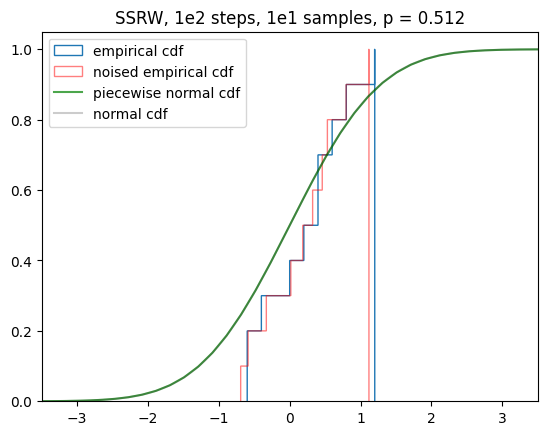

In [16]:
log_n = 1;log_length = 2
p, samples, samples_noised, piecewise_cdf = test_pvalue(log_n,log_length)
# plot samples cumulative hist
# high resolution figure
# plt.figure(figsize=(30, 30))
plt.hist(samples, bins=1000, density=True, cumulative=True, histtype='step', label='empirical cdf')
plt.hist(samples_noised, bins=1000, density=True, cumulative=True, 
histtype='step', color='red', alpha=0.5, label='noised empirical cdf')
x= np.linspace(-5, 5, 10000)
plt.plot(x, piecewise_cdf(x), color='green', alpha = 0.7, label='piecewise normal cdf')
plt.plot(x, stats.norm.cdf(x), color='black', alpha = 0.2, label='normal cdf')
plt.xlim(-3.5, 3.5)
plt.legend()
# title: __ steps, __ samples
plt.title(f'SSRW, 1e{log_length} steps, 1e{log_n} samples, p = {p:.3f}')
plt.show()

# Running Adapted KS test

In [23]:
pvalue = lambda log_n, log_length: adapted_ks_1samp_pvalue(log_n, log_length, sample_fn=sample_from_cauchy)[0]
x = np.linspace(1, 4, 13)
y = np.linspace(1, 4,13)
X, Y = np.meshgrid(x, y)
Z = np.vectorize(pvalue)(X, Y)
# np.save('pvalue.npy', Z)
# print('saved')


## SSRW

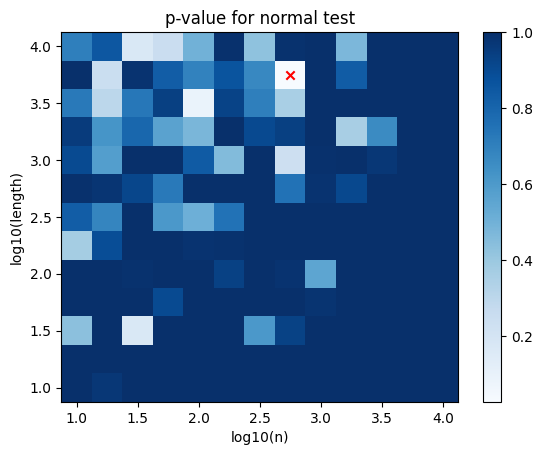

In [18]:
# Load results.npy
# Z = np.load('../results.npy')
plt.pcolormesh(X, Y, Z)

plt.colorbar()
# blues colorscheme
plt.set_cmap('Blues')
plt.xlabel('log10(n)')
plt.ylabel('log10(length)')
plt.title('p-value for normal test')
# put a red x on the points with value smaller than 0.05
plt.scatter(X[Z<0.05], Y[Z<0.05], marker='x', color='red')
plt.show()

### Interpretation

For $m < n$ the test becomes very optimistic, and the p-value is very close to 1. This is because the bound for $D_{m, n}$ we are using become very loose when $m$ is small. The test is still valid, but the p-value is not very informative. For $m \gg n$ the test behaves just like the KS test.


## RW generated by Standard Cauchy

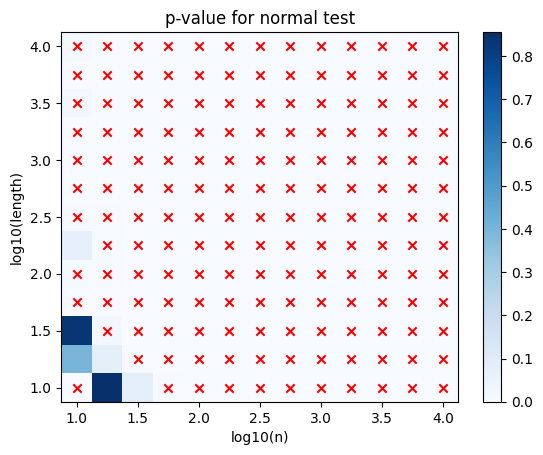

In [24]:
# Load results.npy
# Z = np.load('../results.npy')
plt.pcolormesh(X, Y, Z)

plt.colorbar()
# blues colorscheme
plt.set_cmap('Blues')
plt.xlabel('log10(n)')
plt.ylabel('log10(length)')
plt.title('p-value for normal test')
# put a red x on the points with value smaller than 0.05
plt.scatter(X[Z<0.05], Y[Z<0.05], marker='x', color='red')
plt.show()

### Interpretation

The test behaves as expected, rejecting the null hypothesis when $m, n$ become large. When $m, n$ are close to $0$, the test fails to reject the null hypothesis, which is expected since we don't have enough data to reject the null hypothesis.

# CDF of $D_{m, n}$

In [19]:
from scipy.stats import distributions
from scipy.optimize import fsolve
n = 100 ; m = 10000
# a = distributions.ksone.cdf(D, N) # L function
def L(d, n):
    """
    $L(d, n) = P(K_n <= d / sqrt(n))$
    """
    return distributions.kstwo.cdf(d / n**0.5, n)

def L_inv(p, n):
    return fsolve(lambda D: L(D, n) - p, 1)

L_inv(0.80, n)


array([1.05605438])

In [20]:
def p_bound(v, m, n):
    r = n / m
    return [
        L(v - 0.4748*r, n),
        L(v + 0.4748*r, n)
    ]

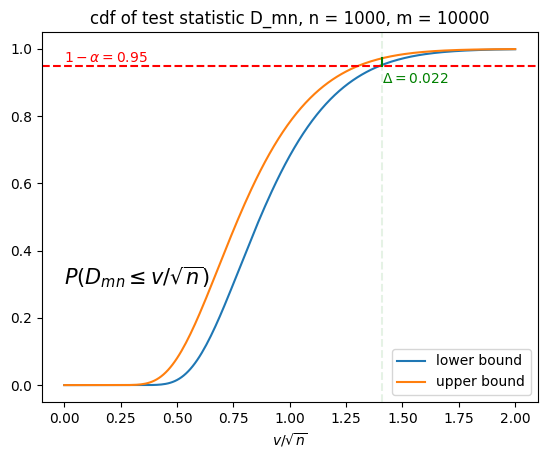

In [22]:
# plot p_bound
n = 1000 ; m = 10000
x = np.linspace(0, 2, 201)
y = np.array([p_bound(v, m, n) for v in x])
plt.plot(x, y[:,0], label='lower bound')
plt.plot(x, y[:,1], label='upper bound')
plt.legend()
# plt.ylim(0.00001,1)
# horizontal line at 0.05
plt.axhline(0.95, color='red', linestyle='--')
plt.text(0.0, 0.96, r'$1-\alpha = 0.95$', color='red')

# vertical line where lower bound is 0.95
lb_95 = x[y[:,0] > 0.95][0]
# index of lb_95
i = np.where(x == lb_95)[0][0]
plt.axvline(lb_95, color='green', linestyle='--', alpha = 0.1)
# ling segment between lower bound and upper bound at lb_95
plt.plot([lb_95, lb_95], [0.95, y[i,1]], color='green', linestyle='-')

# difference between upper bound and lower bound at lb_95
diff = y[i,1] - 0.95
plt.text(lb_95, 0.9, fr'$\Delta = {diff:.3f}$', color='green')

# log scale
# plt.yscale('log')
plt.title(f'cdf of test statistic D_mn, n = {n}, m = {m}')
plt.xlabel(r'$v/\sqrt{n}$')
# add a equation
plt.text(0.0, 0.3, r'$P(D_{mn} \leq v / \sqrt{n})$', fontsize=15)
plt.show()